In [1]:
import torch
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
from plantcv import plantcv as pcv
from matplotlib.patches import Patch
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchmetrics.detection import IntersectionOverUnion

import matplotlib.pyplot as plt

In [2]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

'C:\\Users\\samko\\Desktop\\Files\\UNI\\DP'

In [2]:
def get_accuracy(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    correct_pixels = np.equal(output, target).sum().item()
    # correct_pixels = 0
    # for w in range(output.shape[0]):
    #     for h in range(output.shape[1]):
    #         if output[w][h] == target[w][h]:
    #             correct_pixels +=1
    total_pixels = target.size

    # print(output.shape)
    # print(output.shape)
    # print(total_pixels)
    # print(correct_pixels)
    accuracy = correct_pixels / total_pixels
    return accuracy

In [3]:
def get_IoU(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    intersection = np.logical_and(output, target).sum().item()
    union = np.logical_or(output, target).sum().item()

    iou = intersection / union if union != 0 else 0.0
    return iou

In [4]:
def dice_coefficient(prediction, target, smooth=1e-5):
    pred = np.copy(prediction)
    tar = np.copy(target)

    pred = torch.from_numpy(pred)
    tar = torch.from_numpy(tar)
    
    intersection = torch.sum(pred * tar)
    union = torch.sum(pred) + torch.sum(tar)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.item()

In [5]:
def confusion_matrix(prediction, target):
    output = np.copy(prediction)
    check = 1
    # if flag == "disk":
    #     check = 1
        
    total = output.size
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    postive = 0
    negative = 0
    for w in range(output.shape[0]):
        for h in range(output.shape[1]):
            if check == 1 and target[w][h]==1:
                postive+=1
            if target[w][h] == 0:
                negative +=1
                
            if target[w][h] == check and output[w][h] ==check:
                TP +=1
                output[w][h] = 3
                continue
            if target[w][h] != check and output[w][h] !=check:
                TN +=1
                output[w][h] = 4
                continue
            if target[w][h] != check and output[w][h] == check:
                FP +=1
                output[w][h] = 5
                continue
            if target[w][h] == check and output[w][h] != check:
                FN += 1
                output[w][h] = 6
                continue

    output = output.astype(np.uint8)
    image = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)
    print(output.shape)
    image[output[:,:] == 3] = [0, 255, 0] #TP GREEN
    image[output[:,:] == 4] = [0, 0, 255] #TN blue
    image[output[:,:] == 5] = [255, 0, 0] # FP red
    image[output[:,:] == 6] = [255, 255, 0] #FN yellow
    
    return TP/total, TN/total, FP/total, FN/total, image

In [6]:
res34_disk_acc = 0
res34_cup_acc = 0
res34_cup_255_acc = 0
res34_cup_128_acc = 0
res18_disk_acc = 0

res34_disk_iou = 0
res34_cup_iou = 0
res34_cup_255_iou = 0
res34_cup_128_iou = 0
res18_disk_iou = 0

res34_disk_dice = 0
res34_cup_dice = 0
res34_cup_255_dice = 0
res34_cup_128_dice = 0
res18_disk_dice = 0

# RESNET34

## TEST_RESULTS_DISK

In [7]:
image = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test\633.jpg')
predicted = loadmat(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_results_disk\633.mat').get('mask')
predicted = np.squeeze(predicted, axis=-1)
ground_truth = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_gt\633.png')
ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
ground_truth = np.array(ground_truth)
ground_truth[ground_truth == 2] =1

In [8]:
get_accuracy(predicted, ground_truth)

0.95831298828125

In [9]:
get_IoU(predicted, ground_truth)

0.8335262933398331

In [10]:
dice_coefficient(predicted, ground_truth)

0.9092057347297668

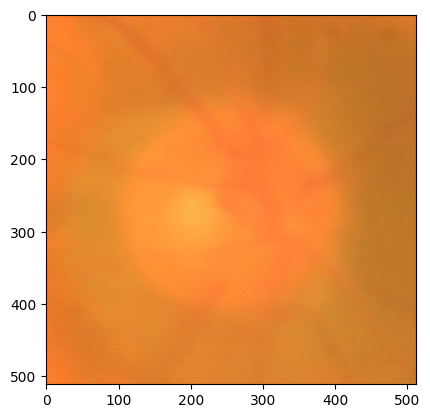

In [11]:
plt.imshow(image)

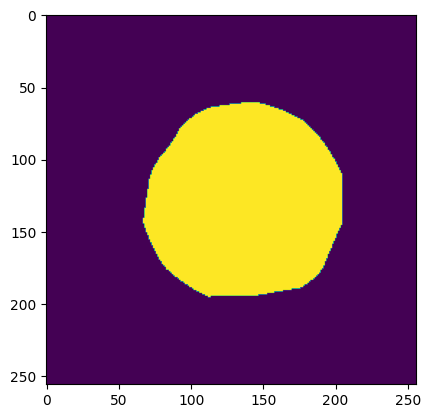

In [12]:
plt.imshow(predicted)

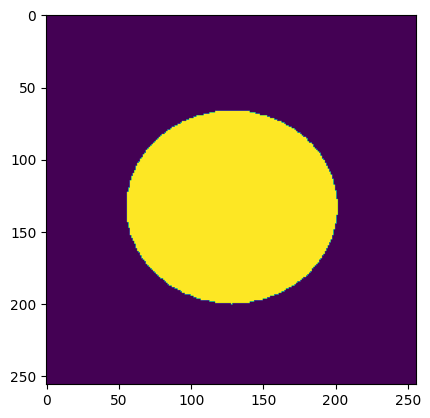

In [13]:
plt.imshow(ground_truth)

In [14]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth)

(256, 256)


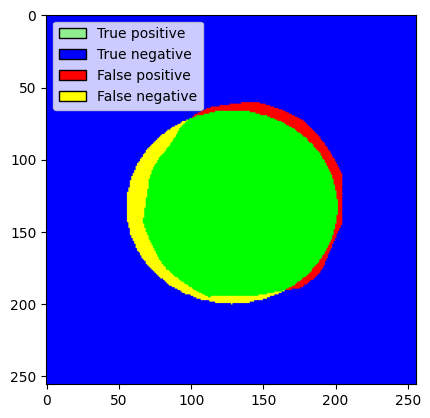

In [15]:
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')
plt.imshow(comparison_disk)

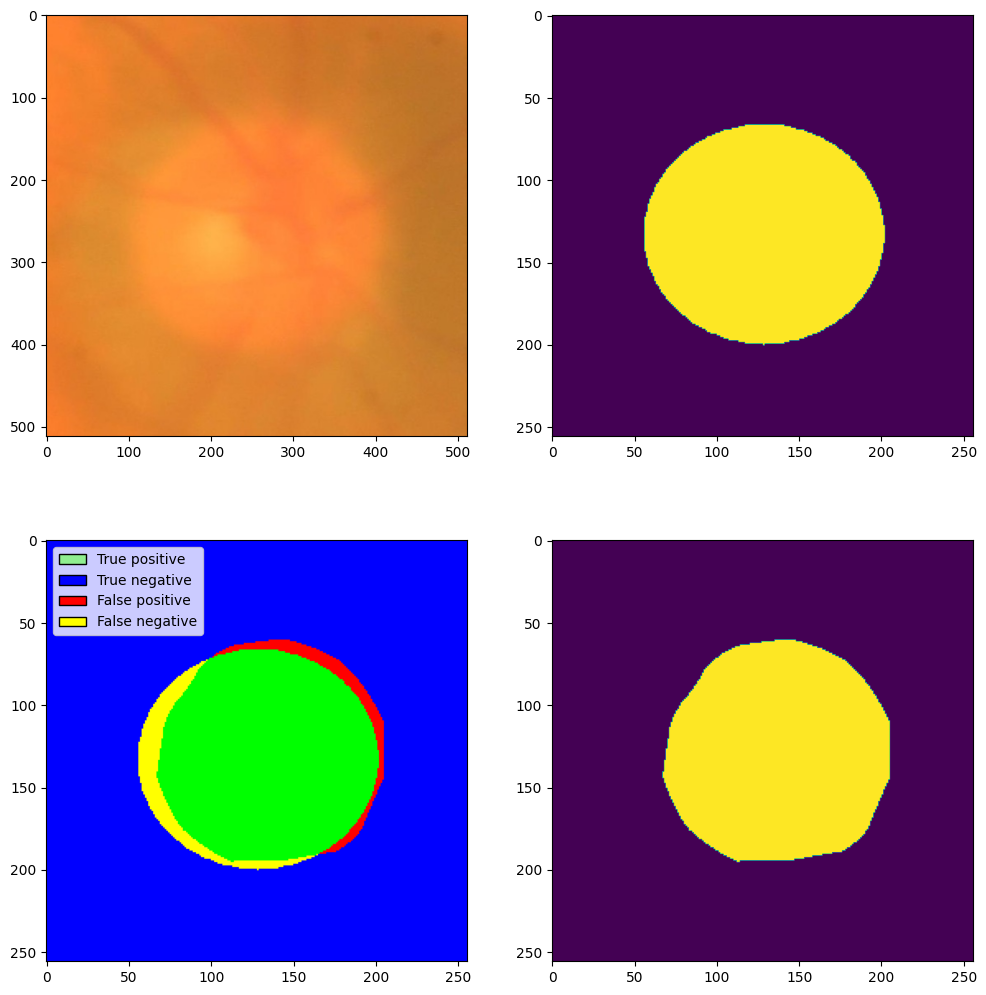

In [16]:
plt.figure(figsize=(25,25))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')

# Show the plot
plt.show()

In [17]:
images_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test'
prediction_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_results_disk'
ground_truth_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_gt'

In [18]:
images_list = os.listdir(images_path)
predicted_list = os.listdir(prediction_path)
ground_truth_list = os.listdir(ground_truth_path)

In [19]:
global_acc_test = 0
res34_disk_acc_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    
    acc = get_accuracy(predicted, ground_truth)
    print(acc)
    global_acc_test += acc
    res34_disk_acc_array.append(acc)
global_acc_test = global_acc_test/len(images_list)

0.9586181640625
0.9502410888671875
0.9597320556640625
0.9168701171875
0.9716949462890625
0.942413330078125
0.9518280029296875
0.972625732421875
0.891204833984375
0.9445343017578125
0.95281982421875
0.957275390625
0.9701385498046875
0.97711181640625
0.97784423828125
0.9770660400390625
0.9565887451171875
0.9838104248046875
0.9679107666015625
0.98321533203125
0.9848175048828125
0.90521240234375
0.98590087890625
0.9151458740234375
0.9724578857421875
0.9580078125
0.9820556640625
0.9841766357421875
0.9549560546875
0.9372711181640625
0.951446533203125
0.9297637939453125
0.95831298828125
0.961517333984375
0.9551544189453125
0.8789215087890625
0.9534759521484375
0.9725494384765625
0.9770965576171875
0.953369140625
0.9539642333984375
0.9510040283203125
0.9697113037109375
0.9612579345703125
0.9627838134765625
0.960540771484375
0.9609375
0.915008544921875
0.9671478271484375
0.92694091796875


In [20]:
res34_disk_acc = global_acc_test
global_acc_test

0.9552890014648437

In [21]:
global_iou_test = 0
res34_disk_iou_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    
    iou = get_IoU(predicted, ground_truth)
    #print(iou)
    global_iou_test += iou
    res34_disk_iou_array.append(iou)
global_iou_test = global_iou_test/len(images_list)

In [22]:
res34_disk_iou = global_iou_test
global_iou_test

0.869515627498106

In [23]:
global_dice_test = 0
res34_disk_dice_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    dice = dice_coefficient(torch.from_numpy(predicted), torch.from_numpy(ground_truth))
    print(dice)
    global_dice_test += dice
    res34_disk_dice_array.append(dice)
global_dice_test = global_dice_test/len(images_list)

0.9369624853134155
0.9194954037666321
0.9330525994300842
0.8817194700241089
0.9532521963119507
0.893081784248352
0.9200294017791748
0.9549223780632019
0.8635563254356384
0.9223008155822754
0.9114851951599121
0.9080097079277039
0.9470236301422119
0.9617444276809692
0.9580734372138977
0.9626574516296387
0.922312319278717
0.968334972858429
0.943626880645752
0.9712207913398743
0.9761602282524109
0.8654654026031494
0.9802749752998352
0.9168199896812439
0.9650227427482605
0.9456706047058105
0.9683257937431335
0.9742469191551208
0.92685467004776
0.9043664336204529
0.9264753460884094
0.8994824290275574
0.9092057347297668
0.9301424026489258
0.917469322681427
0.7820115089416504
0.9308161735534668
0.9574835300445557
0.9594115614891052
0.9154399633407593
0.9257134199142456
0.9301941394805908
0.9600611925125122
0.9531679153442383
0.935861349105835
0.941400408744812
0.93284010887146
0.8500592112541199
0.9482762813568115
0.8890947699546814


In [24]:
res34_disk_dice = global_dice_test
global_dice_test

0.929013524055481

## TEST_RESULTS_CUP

In [25]:
image = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test\610.jpg')
predicted = loadmat(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_results_cup\610.mat').get('mask')
predicted = np.squeeze(predicted, axis=-1)
ground_truth = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_gt\610.png')
ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
ground_truth = np.array(ground_truth)
ground_truth[ground_truth == 1] =0
ground_truth[ground_truth == 2] =1

In [26]:
get_accuracy(predicted, ground_truth)

0.8721466064453125

In [27]:
get_IoU(predicted, ground_truth)

0.24465879383394934

In [28]:
dice_coefficient(predicted, ground_truth)

0.39313390851020813

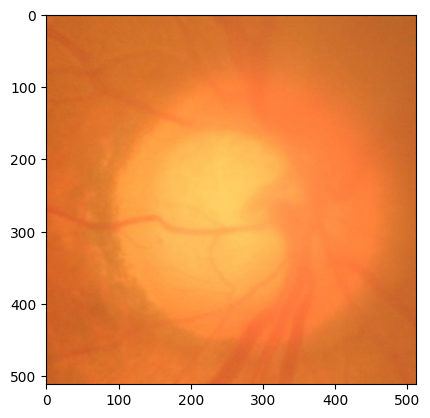

In [29]:
plt.imshow(image)

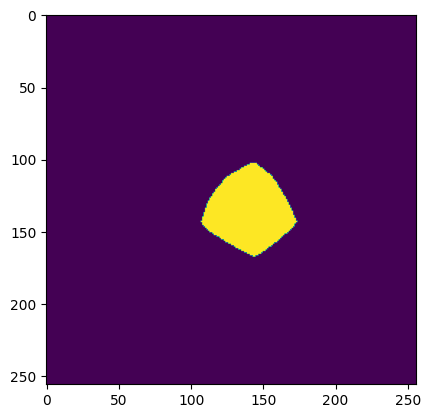

In [30]:
plt.imshow(predicted)

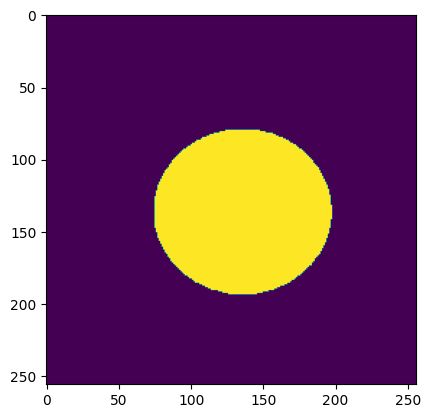

In [31]:
plt.imshow(ground_truth)

In [32]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth)

(256, 256)


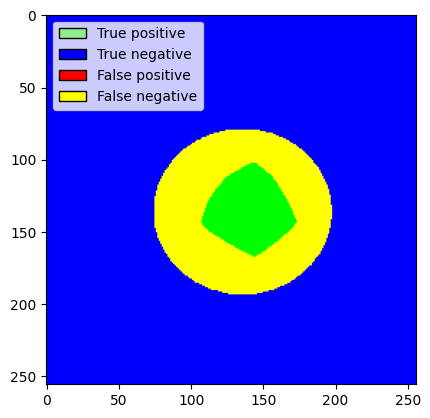

In [33]:
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')

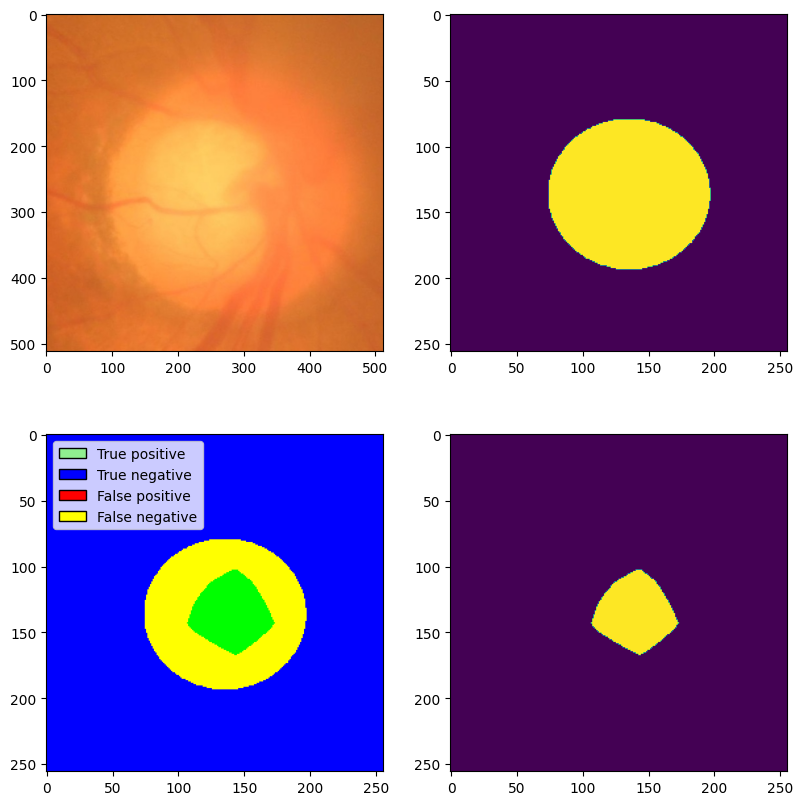

In [34]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')

In [35]:
images_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test'
prediction_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_results_cup'
ground_truth_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_gt'

In [36]:
images_list = os.listdir(images_path)
predicted_list = os.listdir(prediction_path)
ground_truth_list = os.listdir(ground_truth_path)

In [37]:
global_acc_test = 0
res34_cup_acc_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    
    acc = get_accuracy(predicted, ground_truth)
    print(acc)
    global_acc_test += acc
    res34_cup_acc_array.append(acc)
global_acc_test = global_acc_test/len(images_list)

0.950531005859375
0.9511871337890625
0.92376708984375
0.9558563232421875
0.8960113525390625
0.96917724609375
0.9562835693359375
0.9639892578125
0.9431915283203125
0.8721466064453125
0.9776458740234375
0.988616943359375
0.95159912109375
0.970947265625
0.9730072021484375
0.9562225341796875
0.982208251953125
0.95489501953125
0.9821929931640625
0.971160888671875
0.9181060791015625
0.8878173828125
0.9592742919921875
0.928131103515625
0.9425506591796875
0.9293212890625
0.9763641357421875
0.9495849609375
0.9389801025390625
0.92095947265625
0.9300079345703125
0.9463958740234375
0.9846649169921875
0.9817352294921875
0.941253662109375
0.917022705078125
0.967987060546875
0.9473724365234375
0.964752197265625
0.9547576904296875
0.9674072265625
0.9644927978515625
0.9651031494140625
0.97833251953125
0.9762725830078125
0.9870147705078125
0.9220123291015625
0.9661102294921875
0.945068359375
0.9134063720703125


In [38]:
res34_cup_acc = global_acc_test
global_acc_test

0.9512579345703125

In [39]:
global_iou_test = 0
res34_cup_iou_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    
    iou = get_IoU(predicted, ground_truth)
    #print(iou)
    global_iou_test += iou
    res34_cup_iou_array.append(iou)
global_iou_test = global_iou_test/len(images_list)

In [40]:
res34_cup_iou = global_iou_test
global_iou_test

0.6496701332307145

In [41]:
global_dice_test = 0
res34_cup_dice_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    dice = dice_coefficient(torch.from_numpy(predicted), torch.from_numpy(ground_truth))
    print(dice)
    global_dice_test += dice
    res34_cup_dice_array.append(dice)
global_dice_test = global_dice_test/len(images_list)

0.8165874481201172
0.6613022685050964
0.6442608833312988
0.8779273629188538
0.5397447347640991
0.8398351073265076
0.8005291223526001
0.8382009863853455
0.8052518963813782
0.39313390851020813
0.8983274102210999
0.9322187900543213
0.8622426986694336
0.9101971387863159
0.8571197986602783
0.6475862860679626
0.9056023359298706
0.7998917102813721
0.9170280694961548
0.8822429776191711
0.7787807583808899
0.43852147459983826
0.8410079479217529
0.8433862924575806
0.8287780284881592
0.7620221972465515
0.8598062992095947
0.7938607335090637
0.7093961238861084
0.5722543597221375
0.5920853614807129
0.768500804901123
0.8661249279975891
0.8634964227676392
0.6251947283744812
0.438455194234848
0.8654438257217407
0.7899385094642639
0.6702826023101807
0.748109757900238
0.8353884220123291
0.8685830235481262
0.8949230313301086
0.9381048083305359
0.905843198299408
0.9547075629234314
0.6733559370040894
0.8302117586135864
0.691463828086853
0.6253877878189087


In [42]:
res34_cup_dice = global_dice_test
global_dice_test

0.7740529328584671

## TEST_RESULTS_CUP_WITH_CONTEXT_255

In [43]:
image = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test\610.jpg')
predicted = loadmat(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_results_cup_255\610.mat').get('mask')
#predicted = np.squeeze(predicted, axis=-1)
predicted = predicted[:,:,2]
ground_truth = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_gt\610.png')
ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
ground_truth = np.array(ground_truth)
ground_truth[ground_truth == 1] =0
ground_truth[ground_truth == 2] =1

In [44]:
get_accuracy(predicted, ground_truth)

0.9540863037109375

In [45]:
get_IoU(predicted, ground_truth)

0.7289189189189189

In [46]:
dice_coefficient(predicted, ground_truth)

0.8432077765464783

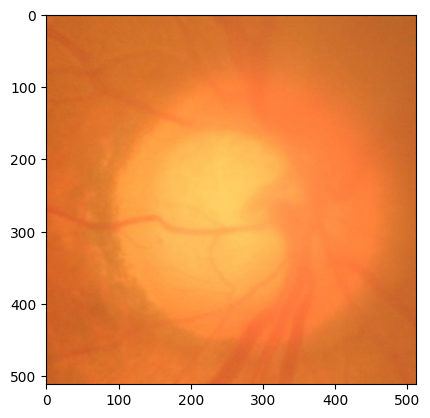

In [47]:
plt.imshow(image)

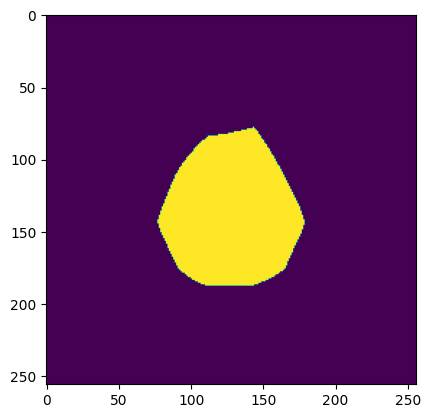

In [48]:
plt.imshow(predicted)

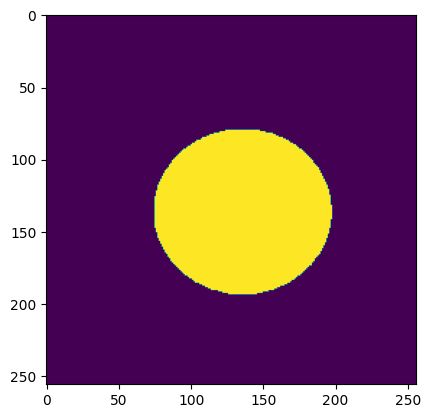

In [49]:
plt.imshow(ground_truth)

In [50]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth)

(256, 256)


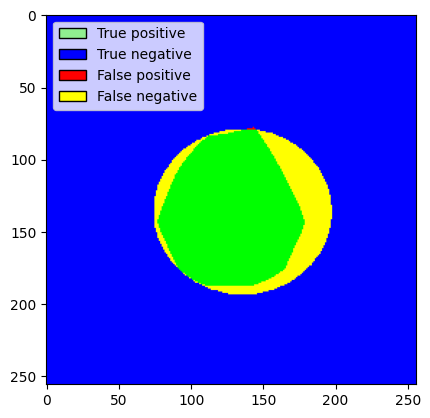

In [51]:
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')
plt.imshow(comparison_disk)

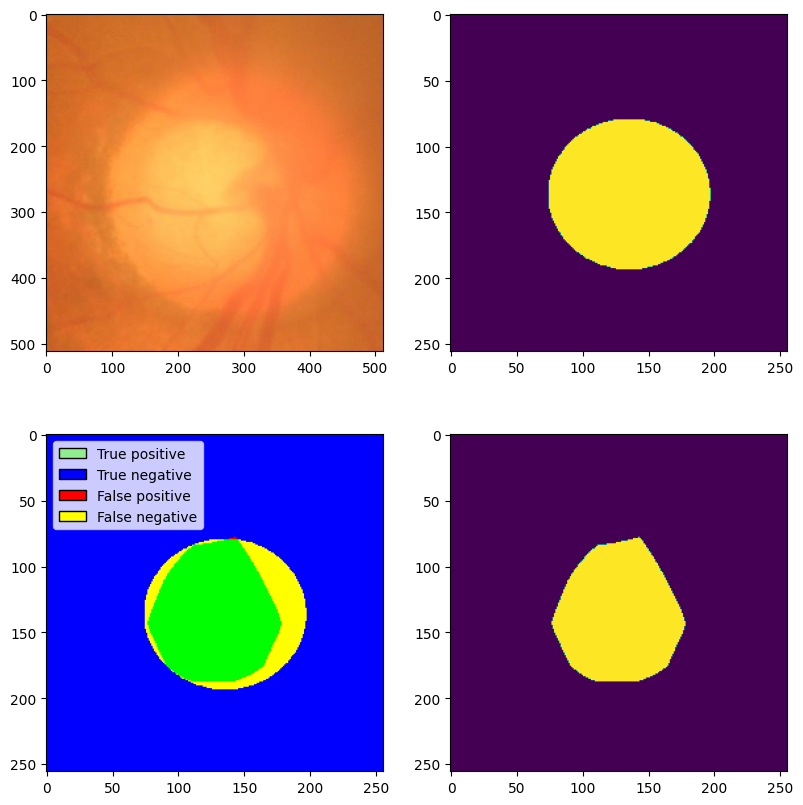

In [52]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')

In [53]:
images_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test'
prediction_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_results_cup_255'
ground_truth_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_gt'

In [54]:
images_list = os.listdir(images_path)
predicted_list = os.listdir(prediction_path)
ground_truth_list = os.listdir(ground_truth_path)

In [55]:
global_acc_test = 0
res34_cup_255_acc_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = predicted[:,:,2]
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    
    acc = get_accuracy(predicted, ground_truth)
    print(acc)
    global_acc_test += acc
    res34_cup_255_acc_array.append(acc)
global_acc_test = global_acc_test/len(images_list)

0.9730682373046875
0.9575347900390625
0.9597015380859375
0.9434051513671875
0.967620849609375
0.9389495849609375
0.9598388671875
0.95135498046875
0.9585418701171875
0.9540863037109375
0.945068359375
0.938446044921875
0.96405029296875
0.95892333984375
0.96173095703125
0.9073486328125
0.9348602294921875
0.959014892578125
0.9449920654296875
0.955810546875
0.962066650390625
0.9681549072265625
0.9232177734375
0.9371185302734375
0.934356689453125
0.8922882080078125
0.91400146484375
0.939483642578125
0.94647216796875
0.93646240234375
0.9701080322265625
0.9632720947265625
0.963653564453125
0.9528045654296875
0.948699951171875
0.9429931640625
0.93707275390625
0.9306182861328125
0.9510040283203125
0.9582977294921875
0.9396514892578125
0.94024658203125
0.947509765625
0.9612274169921875
0.9742584228515625
0.933502197265625
0.98358154296875
0.968292236328125
0.9520416259765625
0.9650115966796875


In [56]:
res34_cup_255_acc = global_acc_test
global_acc_test

0.9494363403320313

In [57]:
global_iou_test = 0
res34_cup_255_iou_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = predicted[:,:,2]
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    
    iou = get_IoU(predicted, ground_truth)
    #print(iou)
    global_iou_test += iou
    res34_cup_255_iou_array.append(iou)
global_iou_test = global_iou_test/len(images_list)

In [58]:
res34_cup_255_iou = global_iou_test
global_iou_test

0.6948696474771066

In [59]:
global_dice_test = 0
res34_cup_255_dice_array= []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = predicted[:,:,2]
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    dice = dice_coefficient(torch.from_numpy(predicted), torch.from_numpy(ground_truth))
    print(dice)
    global_dice_test += dice
    res34_cup_255_dice_array.append(dice)
global_dice_test = global_dice_test/len(images_list)

0.9176734089851379
0.8163884878158569
0.8692509531974792
0.863303005695343
0.9040253162384033
0.7258274555206299
0.859491765499115
0.8244686722755432
0.8781996965408325
0.8432077765464783
0.7826611995697021
0.7286425232887268
0.9010666012763977
0.8923802375793457
0.830586314201355
0.48446255922317505
0.7557920217514038
0.8500446677207947
0.8018251061439514
0.8515937328338623
0.9100058078765869
0.8888770341873169
0.7595565915107727
0.8812015056610107
0.8353994488716125
0.690462589263916
0.6452221870422363
0.7970317006111145
0.7979030013084412
0.7476669549942017
0.8697559833526611
0.883172333240509
0.7504191398620605
0.755629301071167
0.7662680745124817
0.7526810765266418
0.7711431980133057
0.7404235601425171
0.7436327338218689
0.8042123317718506
0.7864124774932861
0.8087703585624695
0.8658660054206848
0.9039936661720276
0.9144913554191589
0.8090606331825256
0.9493026733398438
0.8496382236480713
0.8039178848266602
0.8794236779212952


In [60]:
res34_cup_255_dice = global_dice_test
global_dice_test

0.8148486602306366

## TEST_RESULTS_CUP_WITH_CONTEXT_128

In [61]:
image = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test\615.jpg')
predicted = loadmat(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_results_cup_128\615.mat').get('mask')
predicted = predicted[:,:,2]
ground_truth = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_gt\615.png')
ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
ground_truth = np.array(ground_truth)
ground_truth[ground_truth == 1] =0
ground_truth[ground_truth == 2] =1

In [62]:
get_accuracy(predicted, ground_truth)

0.9308013916015625

In [63]:
get_IoU(predicted, ground_truth)

0.5943649373881932

In [64]:
dice_coefficient(predicted, ground_truth)

0.7455820441246033

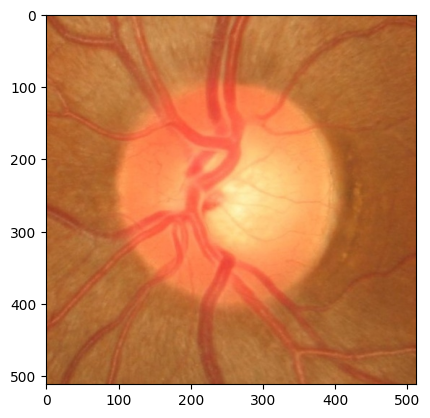

In [65]:
plt.imshow(image)

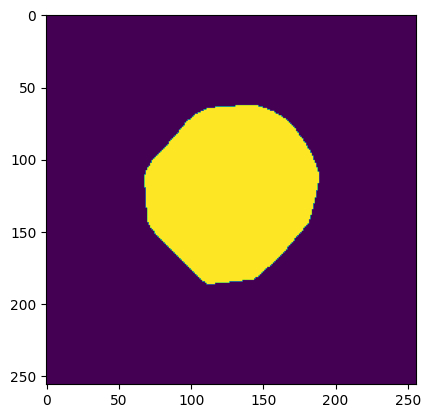

In [66]:
plt.imshow(predicted)

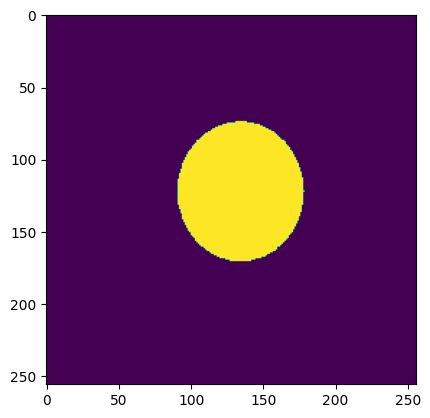

In [67]:
plt.imshow(ground_truth)

In [68]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth)

(256, 256)


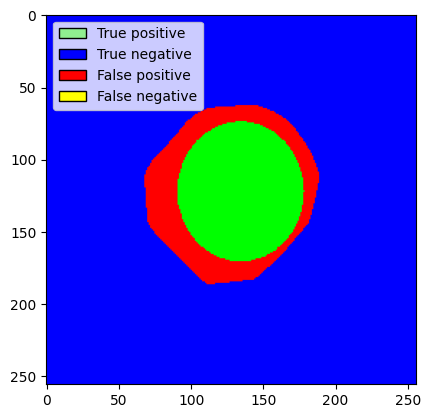

In [69]:
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')
plt.imshow(comparison_disk)

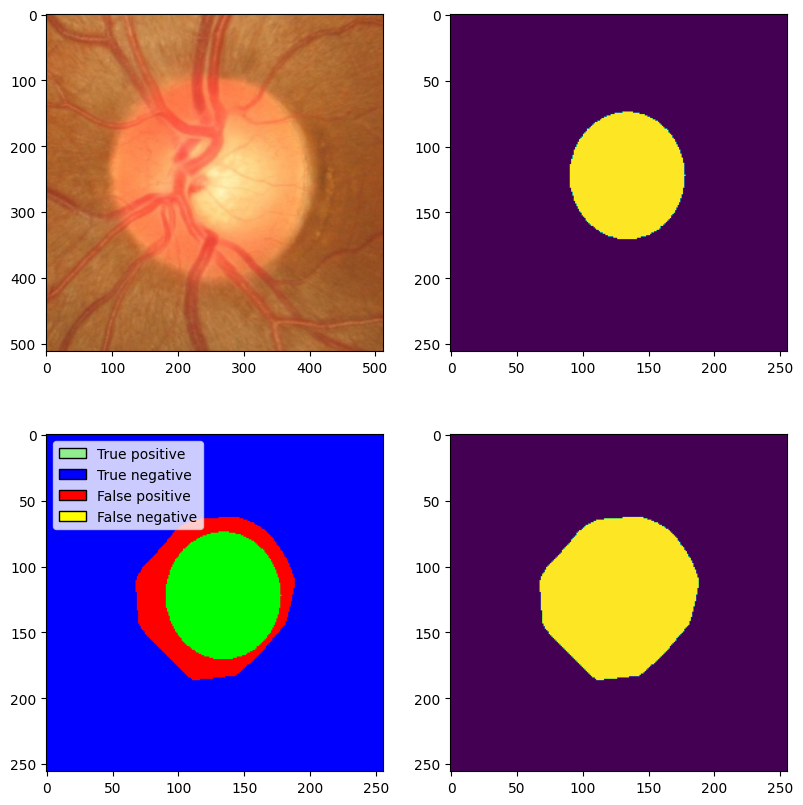

In [70]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')

In [71]:
images_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test'
prediction_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_results_cup_128'
ground_truth_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34\Test_gt'

In [72]:
images_list = os.listdir(images_path)
predicted_list = os.listdir(prediction_path)
ground_truth_list = os.listdir(ground_truth_path)

In [73]:
global_acc_test = 0
res34_cup_128_acc_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = predicted[:,:,2]
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    
    acc = get_accuracy(predicted, ground_truth)
    print(acc)
    global_acc_test += acc
    res34_cup_128_acc_array.append(acc)
global_acc_test = global_acc_test/len(images_list)

0.954071044921875
0.93206787109375
0.9370574951171875
0.935272216796875
0.9392242431640625
0.898345947265625
0.949127197265625
0.9309539794921875
0.9216156005859375
0.9748077392578125
0.9333343505859375
0.9409637451171875
0.95758056640625
0.9556121826171875
0.9308013916015625
0.869598388671875
0.919952392578125
0.9493408203125
0.9215545654296875
0.9448394775390625
0.9434051513671875
0.959930419921875
0.9119415283203125
0.9377899169921875
0.90655517578125
0.8829803466796875
0.8920745849609375
0.92138671875
0.9111328125
0.9179840087890625
0.954010009765625
0.9288787841796875
0.9299774169921875
0.907928466796875
0.954010009765625
0.890655517578125
0.9128570556640625
0.893768310546875
0.91278076171875
0.9320220947265625
0.927734375
0.9013214111328125
0.925140380859375
0.9377899169921875
0.9562225341796875
0.9189605712890625
0.9746551513671875
0.922149658203125
0.9004364013671875
0.983154296875


In [74]:
res34_cup_128_acc = global_acc_test
global_acc_test

0.9289151000976562

In [75]:
global_iou_test = 0
res34_cup_128_iou_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = predicted[:,:,2]
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    
    iou = get_IoU(predicted, ground_truth)
    #print(iou)
    global_iou_test += iou
    res34_cup_128_iou_array.append(iou)
global_iou_test = global_iou_test/len(images_list)

In [76]:
res34_cup_128_iou = global_iou_test
global_iou_test

0.631287332945233

In [77]:
global_dice_test = 0
res34_cup_128_dice_array = []
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = predicted[:,:,2]
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 1] =0
    ground_truth[ground_truth == 2] =1
    dice = dice_coefficient(torch.from_numpy(predicted), torch.from_numpy(ground_truth))
    print(dice)
    global_dice_test += dice
    res34_cup_128_dice_array.append(dice)
global_dice_test = global_dice_test/len(images_list)

0.8688796162605286
0.7354094982147217
0.8020538687705994
0.8582597970962524
0.8390381932258606
0.6138866543769836
0.8344587683677673
0.7725101709365845
0.8078548908233643
0.9251824021339417
0.7519727349281311
0.736820638179779
0.8973336219787598
0.8837097883224487
0.7455820441246033
0.40036487579345703
0.7157871723175049
0.8196044564247131
0.7393926978111267
0.8191866874694824
0.869378387928009
0.8834546208381653
0.733650267124176
0.884585976600647
0.7779067158699036
0.679429829120636
0.5916988849639893
0.7514233589172363
0.7248417139053345
0.7311021089553833
0.8397490382194519
0.8003768920898438
0.6193280816078186
0.6131555438041687
0.814019501209259
0.6414849162101746
0.7087264657020569
0.6507124304771423
0.61969393491745
0.7459656596183777
0.7411739230155945
0.719180166721344
0.8190469145774841
0.8544084429740906
0.8629305958747864
0.7766329050064087
0.9252374172210693
0.7133063673973083
0.6763874292373657
0.9480421543121338


In [78]:
res34_cup_128_dice = global_dice_test
global_dice_test

0.7656863844394683

# RESNET18

## TEST_RESULTS_DISK

In [79]:
image = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet18\Test\601.jpg')
predicted = loadmat(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet18\Test_results_disk\601.mat').get('mask')
predicted = np.squeeze(predicted, axis=-1)
ground_truth = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet18\Test_gt\601.png')
ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
ground_truth = np.array(ground_truth)
ground_truth[ground_truth == 2] =1

In [80]:
get_accuracy(predicted, ground_truth)

0.8492584228515625

In [81]:
get_IoU(predicted, ground_truth)

0.5649167620893156

In [82]:
dice_coefficient(predicted, ground_truth)

0.7219767570495605

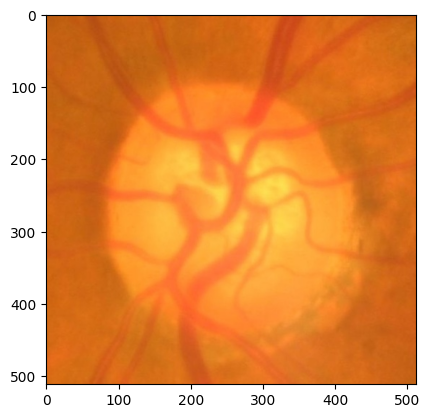

In [83]:
plt.imshow(image)

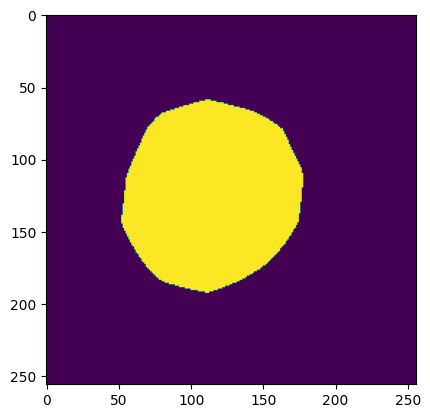

In [84]:
plt.imshow(predicted)

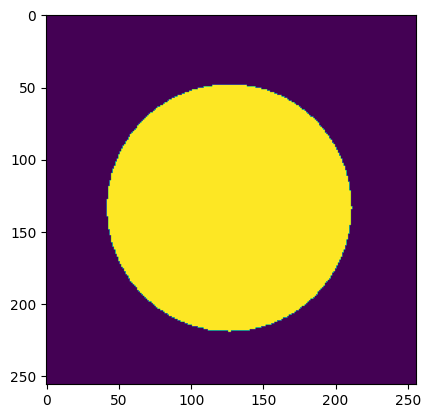

In [85]:
plt.imshow(ground_truth)

In [86]:
TP_disk, TN_disk, FP_disk, FN_disk, comparison_disk = confusion_matrix(predicted, ground_truth)

(256, 256)


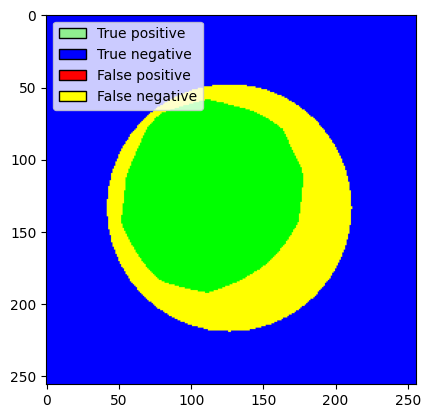

In [87]:
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')
plt.imshow(comparison_disk)

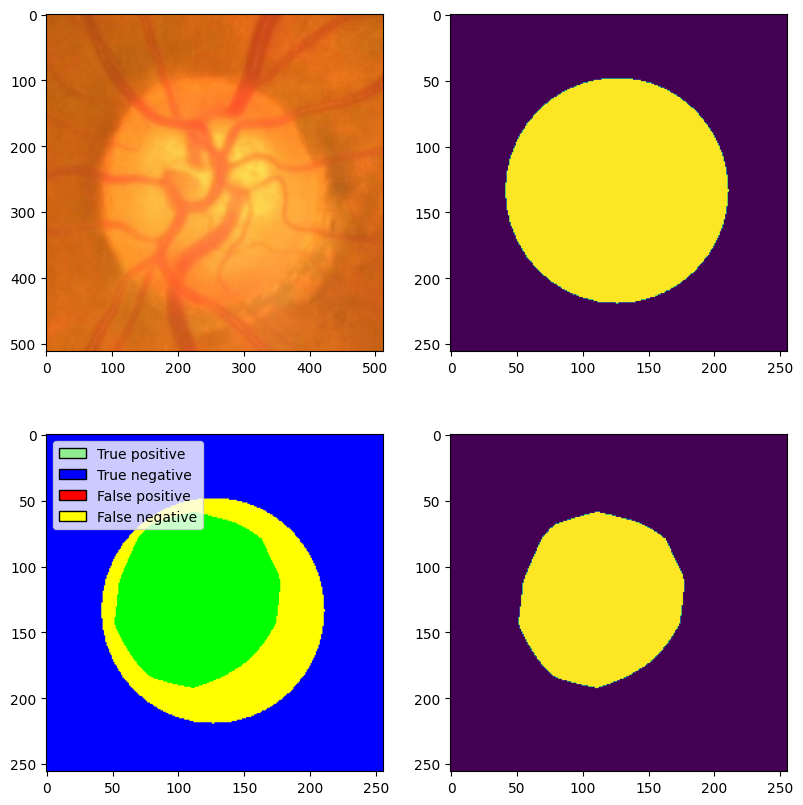

In [88]:
plt.figure(figsize=(20,20))
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)  
plt.subplot(1,4,2)   #
plt.imshow(predicted)
plt.subplot(2,4,2)   #2,4,2
plt.imshow(ground_truth)
plt.subplot(1,4,1)   #1,4,1
plt.imshow(comparison_disk)
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='True positive'),
    Patch(facecolor='blue', edgecolor='black', label='True negative'),
    Patch(facecolor='red', edgecolor='black', label='False positive'),
    Patch(facecolor='yellow', edgecolor='black', label='False negative'),
]
plt.legend(handles=legend_elements, loc='upper left')

In [89]:
images_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet18\Test'
prediction_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet18\Test_results_disk'
ground_truth_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet18\Test_gt'

In [90]:
images_list = os.listdir(images_path)
predicted_list = os.listdir(prediction_path)
ground_truth_list = os.listdir(ground_truth_path)

In [91]:
global_acc_test = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    
    acc = get_accuracy(predicted, ground_truth)
    print(acc)
    global_acc_test += acc
global_acc_test = global_acc_test/len(images_list)

0.8492584228515625
0.7980194091796875
0.9304351806640625
0.8699493408203125
0.9485626220703125
0.9547882080078125
0.9014892578125
0.93353271484375
0.7846832275390625
0.76251220703125
0.92584228515625
0.941375732421875
0.8282318115234375
0.9517364501953125
0.9850006103515625
0.923187255859375
0.9521331787109375
0.9234771728515625
0.93408203125
0.94842529296875
0.9196014404296875
0.682342529296875
0.9775238037109375
0.818817138671875
0.90948486328125
0.88275146484375
0.9213104248046875
0.9362640380859375
0.745574951171875
0.6953125
0.6773529052734375
0.7877197265625
0.76654052734375
0.8082122802734375
0.78436279296875
0.677490234375
0.777496337890625
0.863861083984375
0.88946533203125
0.77947998046875
0.9033966064453125
0.9241180419921875
0.9156646728515625
0.929107666015625
0.9487152099609375
0.931610107421875
0.9217071533203125
0.70751953125
0.9029998779296875
0.8698577880859375


In [92]:
res18_disk_acc = global_acc_test
global_acc_test

0.8660476684570313

In [93]:
global_iou_test = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    
    iou = get_IoU(predicted, ground_truth)
    #print(iou)
    global_iou_test += iou
global_iou_test = global_iou_test/len(images_list)

In [94]:
res18_disk_iou = global_iou_test
global_iou_test

0.5993867692815411

In [95]:
global_dice_test = 0
for prediction,gt in zip(predicted_list, ground_truth_list):
    predicted = loadmat(prediction_path + '\/'+prediction).get('mask')
    predicted = np.squeeze(predicted, axis=-1)
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    ground_truth[ground_truth == 2] =1
    dice = dice_coefficient(torch.from_numpy(predicted), torch.from_numpy(ground_truth))
    print(dice)
    global_dice_test += dice
global_dice_test = global_dice_test/len(images_list)

0.7219767570495605
0.5654443502426147
0.8786240816116333
0.7923599481582642
0.9062803983688354
0.9128196239471436
0.8128695487976074
0.8767820596694946
0.685786783695221
0.5419389009475708
0.8601358532905579
0.8822411298751831
0.5803854465484619
0.9192597270011902
0.9707397222518921
0.8591809272766113
0.9198005795478821
0.8378124833106995
0.8748696446418762
0.9075340628623962
0.8625179529190063
0.3401166498661041
0.9681189656257629
0.8009921908378601
0.8711498975753784
0.8226714730262756
0.8562508821487427
0.888989269733429
0.3657664656639099
0.24870193004608154
0.161411851644516
0.613898754119873
6.535947338903725e-10
0.5175973773002625
0.4208196699619293
4.731264269253188e-10
0.5345972180366516
0.7431778907775879
0.7636232972145081
0.40731626749038696
0.82902592420578
0.8798531293869019
0.8771969079971313
0.9093003273010254
0.9071521162986755
0.8914454579353333
0.857721209526062
0.1860721856355667
0.8234804272651672
0.7781621217727661


In [96]:
res18_disk_dice = global_dice_test
global_dice_test

0.7086793968306818

# Graphs

In [97]:
print(res34_disk_acc)
print(res34_cup_acc)
print(res34_cup_255_acc)
print(res34_cup_128_acc)
print(res18_disk_acc)

0.9552890014648437
0.9512579345703125
0.9494363403320313
0.9289151000976562
0.8660476684570313


In [98]:
print(res34_disk_iou)
print(res34_cup_iou)
print(res34_cup_255_iou)
print(res34_cup_128_iou)
print(res18_disk_iou)

0.869515627498106
0.6496701332307145
0.6948696474771066
0.631287332945233
0.5993867692815411


In [99]:
print(res34_disk_dice)
print(res34_cup_dice)
print(res34_cup_255_dice)
print(res34_cup_128_dice)
print(res18_disk_dice)

0.929013524055481
0.7740529328584671
0.8148486602306366
0.7656863844394683
0.7086793968306818


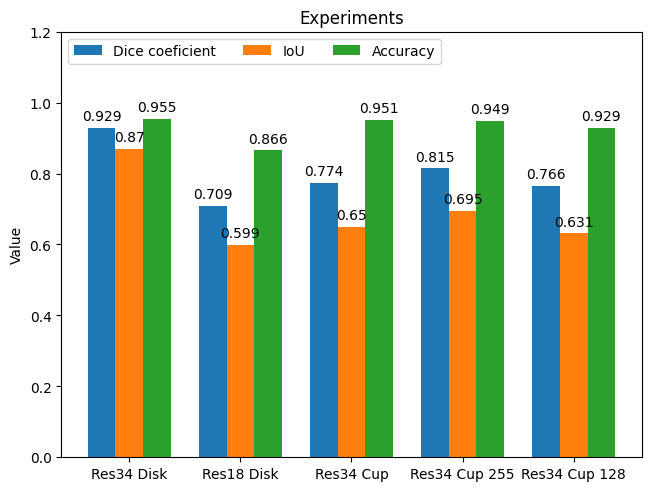

In [100]:

import matplotlib.pyplot as plt
import numpy as np

species = ("Res34 Disk", "Res18 Disk", "Res34 Cup", "Res34 Cup 255", "Res34 Cup 128")
measurements_values = {
    'Dice coeficient': (round(res34_disk_dice,3), round(res18_disk_dice,3), round(res34_cup_dice,3), round(res34_cup_255_dice,3), round(res34_cup_128_dice,3)),
    'IoU': (round(res34_disk_iou,3) ,round(res18_disk_iou,3), round(res34_cup_iou,3), round(res34_cup_255_iou,3), round(res34_cup_128_iou,3)),
    'Accuracy': (round(res34_disk_acc,3), round(res18_disk_acc,3), round(res34_cup_acc,3), round(res34_cup_255_acc,3), round(res34_cup_128_acc,3)),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in measurements_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Experiments')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()

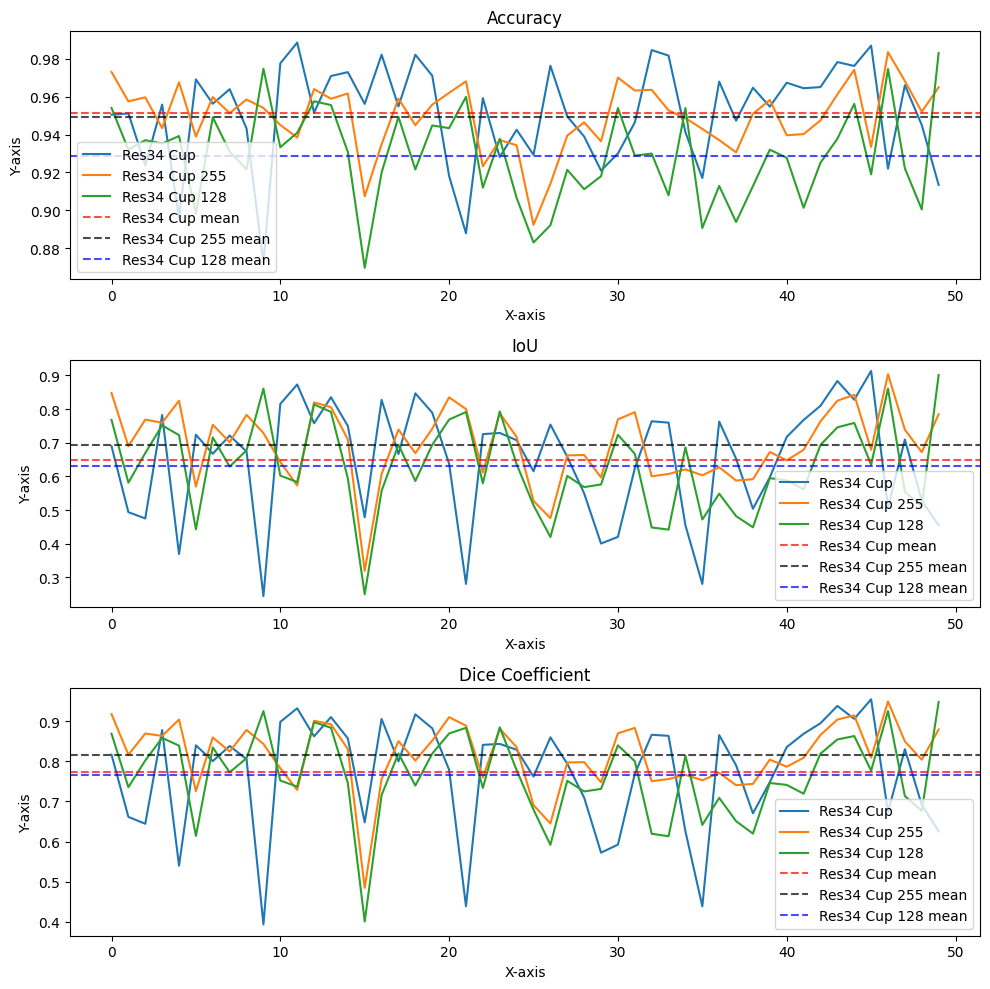

In [105]:
fig, axs = plt.subplots(3, figsize=(10, 10))

axs[0].plot(res34_cup_acc_array, label='Res34 Cup')
axs[0].plot(res34_cup_255_acc_array, label='Res34 Cup 255')
axs[0].plot(res34_cup_128_acc_array, label='Res34 Cup 128')
axs[0].axhline(y=np.mean(res34_cup_acc_array), color='red', alpha=0.7, linestyle='--', label='Res34 Cup mean')
axs[0].axhline(y=np.mean(res34_cup_255_acc_array), color='black', alpha=0.7, linestyle='--', label='Res34 Cup 255 mean')
axs[0].axhline(y=np.mean(res34_cup_128_acc_array), color='blue', alpha=0.7, linestyle='--', label='Res34 Cup 128 mean')

axs[1].plot(res34_cup_iou_array, label='Res34 Cup')
axs[1].plot(res34_cup_255_iou_array, label='Res34 Cup 255')
axs[1].plot(res34_cup_128_iou_array, label='Res34 Cup 128')
axs[1].axhline(y=np.mean(res34_cup_iou_array), color='red', alpha=0.7, linestyle='--', label='Res34 Cup mean')
axs[1].axhline(y=np.mean(res34_cup_255_iou_array), color='black', alpha=0.7, linestyle='--', label='Res34 Cup 255 mean')
axs[1].axhline(y=np.mean(res34_cup_128_iou_array), color='blue', alpha=0.7, linestyle='--', label='Res34 Cup 128 mean')

axs[2].plot(res34_cup_dice_array, label='Res34 Cup')
axs[2].plot(res34_cup_255_dice_array, label='Res34 Cup 255')
axs[2].plot(res34_cup_128_dice_array, label='Res34 Cup 128')
axs[2].axhline(y=np.mean(res34_cup_dice_array), color='red', alpha=0.7, linestyle='--', label='Res34 Cup mean')
axs[2].axhline(y=np.mean(res34_cup_255_dice_array), color='black', alpha=0.7, linestyle='--', label='Res34 Cup 255 mean')
axs[2].axhline(y=np.mean(res34_cup_128_dice_array), color='blue', alpha=0.7, linestyle='--', label='Res34 Cup 128 mean')

axs[0].legend()
axs[1].legend()
axs[2].legend()

# Add labels and title
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].set_title('Accuracy') 

axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')
axs[1].set_title('IoU') 

axs[2].set_xlabel('X-axis')
axs[2].set_ylabel('Y-axis')
axs[2].set_title('Dice Coefficient') 

plt.tight_layout()

plt.show()

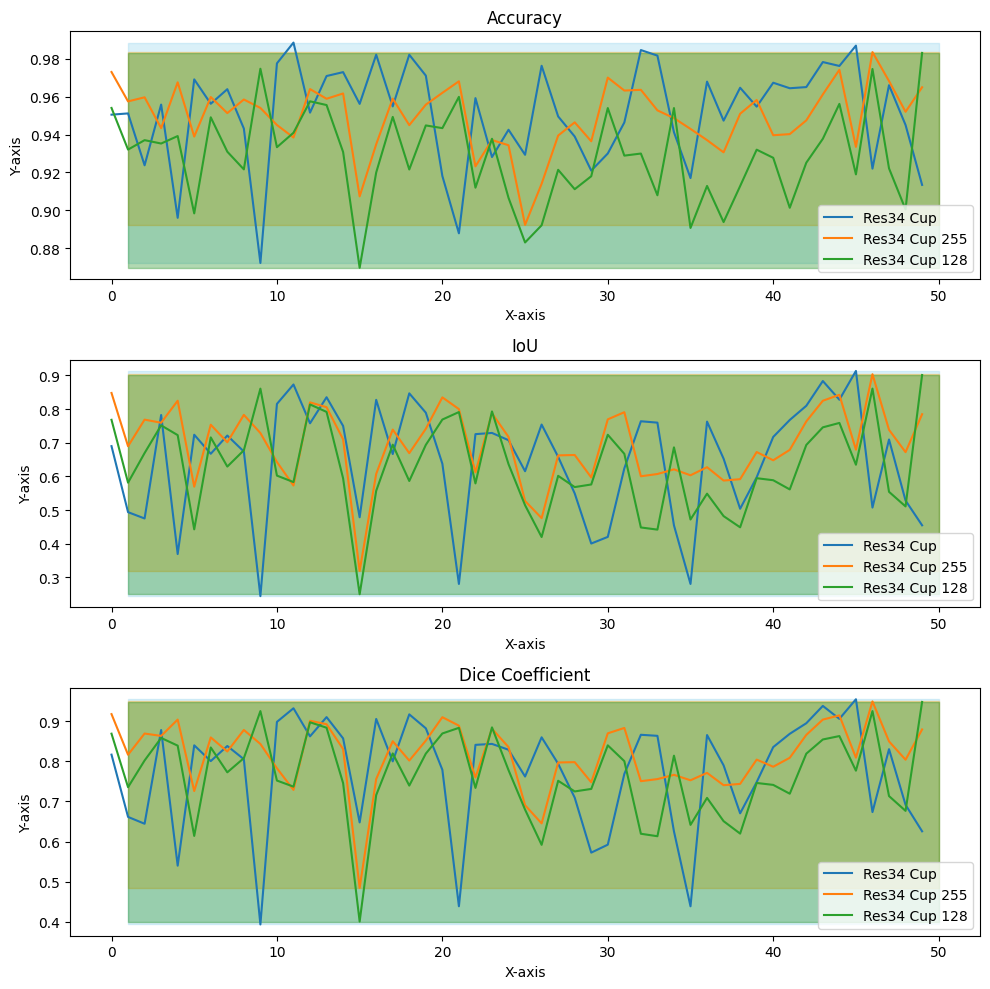

In [104]:
fig, axs = plt.subplots(3, figsize=(10, 10))

axs[0].plot(res34_cup_acc_array, label='Res34 Cup')
axs[0].plot(res34_cup_255_acc_array, label='Res34 Cup 255')
axs[0].plot(res34_cup_128_acc_array, label='Res34 Cup 128')
axs[0].fill_between([i for i in range(1, len(res34_cup_acc_array) + 1)], np.max(res34_cup_acc_array), np.min(res34_cup_acc_array), color='skyblue', alpha=0.3)
axs[0].fill_between([i for i in range(1, len(res34_cup_255_acc_array) + 1)], np.max(res34_cup_255_acc_array), np.min(res34_cup_255_acc_array), color='orange', alpha=0.3)
axs[0].fill_between([i for i in range(1, len(res34_cup_128_acc_array) + 1)], np.max(res34_cup_128_acc_array), np.min(res34_cup_128_acc_array), color='green', alpha=0.3)


axs[1].plot(res34_cup_iou_array, label='Res34 Cup')
axs[1].plot(res34_cup_255_iou_array, label='Res34 Cup 255')
axs[1].plot(res34_cup_128_iou_array, label='Res34 Cup 128')
axs[1].fill_between([i for i in range(1, len(res34_cup_iou_array) + 1)], np.max(res34_cup_iou_array), np.min(res34_cup_iou_array), color='skyblue', alpha=0.3)
axs[1].fill_between([i for i in range(1, len(res34_cup_255_iou_array) + 1)], np.max(res34_cup_255_iou_array), np.min(res34_cup_255_iou_array), color='orange', alpha=0.3)
axs[1].fill_between([i for i in range(1, len(res34_cup_128_iou_array) + 1)], np.max(res34_cup_128_iou_array), np.min(res34_cup_128_iou_array), color='green', alpha=0.3)

axs[2].plot(res34_cup_dice_array, label='Res34 Cup')
axs[2].plot(res34_cup_255_dice_array, label='Res34 Cup 255')
axs[2].plot(res34_cup_128_dice_array, label='Res34 Cup 128')
axs[2].fill_between([i for i in range(1, len(res34_cup_dice_array) + 1)], np.max(res34_cup_dice_array), np.min(res34_cup_dice_array), color='skyblue', alpha=0.3)
axs[2].fill_between([i for i in range(1, len(res34_cup_255_dice_array) + 1)], np.max(res34_cup_255_dice_array), np.min(res34_cup_255_dice_array), color='orange', alpha=0.3)
axs[2].fill_between([i for i in range(1, len(res34_cup_128_dice_array) + 1)], np.max(res34_cup_128_dice_array), np.min(res34_cup_128_dice_array), color='green', alpha=0.3)

axs[0].legend()
axs[1].legend()
axs[2].legend()

# Add labels and title
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].set_title('Accuracy') 

axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')
axs[1].set_title('IoU') 

axs[2].set_xlabel('X-axis')
axs[2].set_ylabel('Y-axis')
axs[2].set_title('Dice Coefficient') 

plt.tight_layout()

plt.show()